In [122]:
# import the relevant packages

from requests import get
from json import dumps
import numpy as np
import pandas as pd

In [74]:
def get_data(api_params):
    
    ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

    response = get(ENDPOINT, params=api_params, timeout=10)

    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
        
    return response.json()

In [177]:
# define out parameters for the API call

AREA_TYPE = "nation"
AREA_NAME = "england"

filters = [
    f"areaType={ AREA_TYPE }",
    f"areaName={ AREA_NAME }"
]

structure = {
    "date": "date",
    "name": "areaName",
    "newCases": "newCasesByPublishDate",
    "newAdmissions": "newAdmissions",
    "newDeaths": "newDeaths28DaysByDeathDate",
    #"P1Tests": "newPillarOneTestsByPublishDate",
    "P2Tests": "newPillarTwoTestsByPublishDate"#,
    #"P3Tests": "newPillarThreeTestsByPublishDate",
    #"P4Tests": "newPillarFourTestsByPublishDate"   
}


api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))
}

In [178]:
# pull in json formatted covid data from the API
englandJson = get_data(api_params)

In [179]:
# extract the desired data

englandPd = pd.DataFrame(englandJson["data"])
#englandPd.fillna(value=0,inplace=True)
englandPd.sort_values(by='date',ascending=True,inplace=True)
englandPd.set_index(keys='date', inplace=True)

englandPd.tail()

,name,newCases,newAdmissions,newDeaths,P2Tests
date,,,,,
2020-08-19,England,707,58.0,0.0,82980.0
2020-08-20,England,1035,17.0,2.0,98085.0
2020-08-21,England,908,NaN,5.0,NaN
2020-08-22,England,1060,NaN,1.0,NaN
2020-08-23,England,938,NaN,NaN,NaN


In [181]:
# add in new columns

for i in range(0,englandPd.shape[0]-6):
    sevenDayCases = 0
    sevenDayAdmissions = 0
    sevenDayDeaths = 0
    sevenDayTests = 0

    for j in range(0,6):
        sevenDayCases += englandPd.iloc[i+j,1]
        sevenDayAdmissions += englandPd.iloc[i+j,2]
        sevenDayDeaths += englandPd.iloc[i+j,3]
        sevenDayTests += englandPd.iloc[i+j,4]

    englandPd.loc[englandPd.index[i+6],'sevenDayMACases'] = np.round( (sevenDayCases / 7) ,1)
    englandPd.loc[englandPd.index[i+6],'sevenDayMAAdmissions'] = np.round( (sevenDayAdmissions / 7) ,1)
    englandPd.loc[englandPd.index[i+6],'sevenDayMADeaths'] = np.round( (sevenDayDeaths / 7) ,1)
    englandPd.loc[englandPd.index[i+6],'sevenDayMATests'] = np.round( (sevenDayTests / 7) ,1)

englandPd["pctAdmissionsPerCase"] = 100.0 * englandPd["sevenDayMAAdmissions"] / englandPd["sevenDayMACases"] 
englandPd["pctDeathsPerCase"] = 100.0 * englandPd["sevenDayMADeaths"] / englandPd["sevenDayMACases"] 
englandPd["pctCasesPerTest"] = 100.0 * englandPd["sevenDayMACases"] / englandPd["sevenDayMATests"]

englandPd = englandPd.replace([np.inf, -np.inf], np.nan)

englandPd.tail()

,name,newCases,newAdmissions,newDeaths,P2Tests,sevenDayMACases,sevenDayMAAdmissions,sevenDayMADeaths,sevenDayMATests,pctAdmissionsPerCase,pctDeathsPerCase,pctCasesPerTest
date,,,,,,,,,,,,
2020-08-19,England,707,58.0,0.0,82980.0,834.0,42.0,6.0,82645.4,5.035971,0.719424,1.009131
2020-08-20,England,1035,17.0,2.0,98085.0,783.7,41.7,5.1,80529.4,5.320914,0.650759,0.973185
2020-08-21,England,908,NaN,5.0,NaN,748.1,36.3,4.7,82051.6,4.852292,0.628258,0.911743
2020-08-22,England,1060,NaN,1.0,NaN,744.4,NaN,4.1,NaN,NaN,0.550779,NaN
2020-08-23,England,938,NaN,NaN,NaN,759.9,NaN,3.9,NaN,NaN,0.513225,NaN


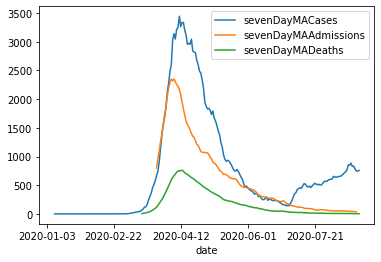

In [182]:
englandPd.plot(kind='line', y=['sevenDayMACases','sevenDayMAAdmissions','sevenDayMADeaths'])

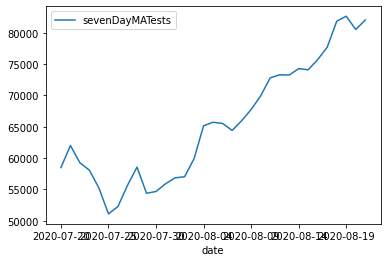

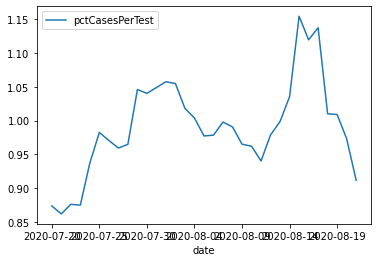

In [185]:
englandPd.loc['2020-07-20' : '2020-12-31'].plot(kind='line', y=['sevenDayMATests'])
englandPd.loc['2020-07-20' : '2020-12-31'].plot(kind='line', y=['pctCasesPerTest'])

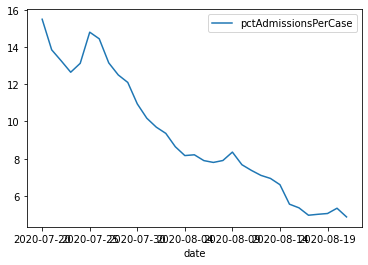

In [189]:
englandPd.loc['2020-07-20' : '2020-12-31'].plot(kind='line', y=['pctAdmissionsPerCase'])